# Model Evaluation & Insights

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
# Import datasets and model
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')
final_train = pd.read_csv('./datasets/final_train.csv')
final_test = pd.read_csv('./datasets/final_test.csv')
submissions = pd.read_csv('./datasets/submissions.csv')

# Loading saved model from previous notebook -- train_lr_gs is our model trained on our 0.7 split of training data. 
# Final_model is the same model as train_lr_gs excepted refitted on both our train and test data -- was used for final submission
train_lr_gs = pickle.load(open('./assets/train_gs_model.sav', 'rb'))
final_model = pickle.load(open('./assets/final_model.sav', 'rb'))

# Loading misclassifications from previous notebook
misclass_array = pickle.load(open('./assets/misclass_array.sav', 'rb'))
misclass_probs = pickle.load(open('./assets/misclass_probs.sav', 'rb'))
misclass_df = pd.DataFrame(data=misclass_array, columns=['Actual', 'Pred'])

### Train Test Split

In [ ]:
final_train = final_train.drop(columns=['Year', 'Sunrise_WeekAvgTemp', 'Sunrise_WetBulb', 'Week_WeekAvgTemp']) # Dropping unused features
final_test = final_test.drop(columns=['Year', 'Sunrise_WeekAvgTemp', 'Sunrise_WetBulb', 'Week_WeekAvgTemp']) # Dropping unused features

X = final_train
y = train['WnvPresent']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

## Model Preparation

In [ ]:
#train_pred = train_lr_gs.predict(X_test)
#train_pred_proba = train_lr_gs.predict_proba(X_test)

## Inferential Analysis of Model

In [ ]:
final_model.best_params_

{'lr__C': 1, 'lr__penalty': 'l1'}

In [ ]:
ss = StandardScaler()
X_sc = ss.fit_transform(X)
X_sc = pd.DataFrame(data=X_sc, columns=X.columns)

In [ ]:
# Adding constant to X so that we can determine model intercept
X_sc = sm.add_constant(X_sc)

In [ ]:
# Fit logistic regression model
model = sm.Logit(y, X_sc).fit_regularized(alpha=1.0)

# Extract logistic regression line slopes
coefs = model.params

# Get the confidence intervals of the slopes
confint = model.conf_int()

# Get p-values of each coeffiecent
pvals = model.pvalues

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.16249364074925507
            Iterations: 399
            Function evaluations: 399
            Gradient evaluations: 399


In [ ]:
# Uncomment below to view full summary of our model
# model.summary()

In [ ]:
sm_coefs = pd.DataFrame(model.params, columns=['coefs'])

In general, it looks like our coefficients from both models (coefs and sm_coefs) are pretty similar -- except for `Week` which seems to have been zeroed out by regularization algorithm used by StatsModel. 

In [ ]:
# Checking to see if our final model comparable with statsmodel model
final_coefs = pd.DataFrame(columns=final_train.columns, data=final_model.best_estimator_.steps[1][1].coef_).T
final_coefs.columns = ['coefs']
final_coefs['sm_coefs'] = sm_coefs['coefs']
final_coefs['p_values'] = pvals
final_coefs['odds'] = np.exp(final_coefs['coefs'])
final_coefs.sort_values(by='coefs', ascending=False).tail(10)[['coefs', 'sm_coefs']]

,coefs,sm_coefs
templag2,-0.009,-0.013
ResultSpeed,-0.028,-0.029
WeekAvgTemp,-0.052,-0.051
AvgSpeed,-0.063,-0.060
Latitude,-0.138,-0.137
lowvis,-0.171,-0.169
rainlag4,-0.246,-0.243
humidlag2,-0.289,-0.287
Longitude,-0.498,-0.497
Depart,-2.302,-2.291


Interestingly, it looks like `WinterDepart` is one of our top three predictors (not counting `Week`). `Tmax` and `Tmin` are also extremely strong predictors for our model. 
On the tail end of this, `Depart` is also another powerful predictor of WNV.

So, looking at the p-values -- what does this tell us? Our null hypothesis for this model is that our odds ratio is 1.0, indicating that there is no association between a feature and our target class `WnvPresent`. 
This means that means that the two odds are equal and our feature isn't useful for predicting the odds of WNV being present.
For example, when it comes to `Tavg`, we are 95% confident that the slope is between 0.512 and 2.270. 
In other words, we can say that higher `Tmax` temperatures are likely to lead to WNV being present, with each  unit increase in Tmax leading to a 4 times increase in probability of `WnvPresent` being labelled as present.

This means that only 15 out of our original 30+ features are statistically significant as their p-value is greater than 0.05.

In [ ]:
# These features are statistically significant
final_coefs[final_coefs['p_values'] < 0.05].sort_values(ascending=False, by='coefs')

,coefs,sm_coefs,p_values,odds
Tmax,1.385,1.391,0.002,3.994
Tmin,0.926,0.936,0.023,2.524
WinterDepart,0.765,0.760,0.000,2.150
Sunrise,0.761,0.761,0.010,2.140
Month,0.643,0.651,0.046,1.903
YearWeek,0.539,0.537,0.000,1.714
Species,0.476,0.475,0.000,1.610
WeekPrecipTotal,0.426,0.425,0.000,1.531
humidlag4,0.250,0.246,0.007,1.284
Trap_T003,0.113,0.113,0.002,1.120


## Misclassification Analysis

In [ ]:
# Preparing dataframe for analysis
full_misclass_df = pd.merge(misclass_df, final_test, left_index=True, right_index=True)

# Retrieving address 
full_misclass_df = pd.merge(full_misclass_df, test, left_index=True, right_index=True)

# Dropping duplicate rows
full_misclass_df = full_misclass_df.drop(columns=['Latitude_y', 'Longitude_y'])

In [ ]:
# Assigning predictions to main dataframe
full_misclass_df['Pred'] = misclass_df['Pred']

# Calculating probability of our postive class occuring, according to our model
misclass_probs_t = [i[1] for i in misclass_probs]
full_misclass_df['PredProbaWNV'] = misclass_probs_t

In [ ]:
full_misclass_df.columns

Index(['Actual', 'Pred', 'WinterDepart', 'templag3', 'templag2', 'Sunrise',
       'Week', 'Species_x', 'Month', 'WeekPrecipTotal', 'templag4', 'DewPoint',
       'WetBulb', 'Tmin', 'Sunset', 'templag1', 'Tavg', 'Longitude_x', 'Cool',
       'WeekAvgTemp', 'rainlag4', 'Heat', 'YearWeek', 'Depart', 'r_humid',
       'n_codesum', 'Tmax', 'ResultSpeed', 'Trap_T900', 'rainlag1',
       'Trap_T143', 'humidlag2', 'Trap_T003', 'AvgSpeed', 'humidlag1',
       'humidlag4', 'Latitude_x', 'lowvis', 'Id', 'Date', 'Address',
       'Species_y', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet',
       'AddressAccuracy', 'PredProbaWNV'],
      dtype='object')

In [ ]:
# Viewing misclassifications -- from here we can check the details of where our model is failing
misclassified = full_misclass_df[full_misclass_df['Actual'] != full_misclass_df['Pred']]
misclassified

,Actual,Pred,WinterDepart,templag3,templag2,Sunrise,Week,Species_x,Month,WeekPrecipTotal,...,Id,Date,Address,Species_y,Block,Street,Trap,AddressNumberAndStreet,AddressAccuracy,PredProbaWNV
13,0,1,-0.300,55.000,60.500,416.000,24,0.000,6,0.710,...,14,2008-06-11,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX TARSALIS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",9,0.878
15,0,1,-0.300,55.000,60.500,416.000,24,0.000,6,0.710,...,16,2008-06-11,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX ERRATICUS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",9,0.797
16,0,1,-0.300,55.000,60.500,416.000,24,2.000,6,0.710,...,17,2008-06-11,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",8,0.829
19,0,1,-0.300,55.000,60.500,416.000,24,0.000,6,0.710,...,20,2008-06-11,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX SALINARIUS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",8,0.521
20,0,1,-0.300,55.000,60.500,416.000,24,0.000,6,0.710,...,21,2008-06-11,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX TERRITANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",8,0.841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3123,0,1,-0.300,73.214,73.429,417.000,26,0.000,6,0.530,...,3124,2008-06-24,"6400 South Stony Island Avenue, Chicago, IL 60...",CULEX ERRATICUS,64,S STONY ISLAND AVE,T077,"6400 S STONY ISLAND AVE, Chicago, IL",8,0.654
3124,0,1,-0.300,73.214,73.429,417.000,26,2.000,6,0.530,...,3125,2008-06-24,"7100 South South Shore Drive, Chicago, IL 6064...",CULEX PIPIENS/RESTUANS,71,S SOUTH SHORE DR,T079,"7100 S SOUTH SHORE DR, Chicago, IL",9,0.826
3129,0,1,-0.300,73.214,73.429,417.000,26,0.000,6,0.530,...,3130,2008-06-24,"7100 South South Shore Drive, Chicago, IL 6064...",CULEX TARSALIS,71,S SOUTH SHORE DR,T079,"7100 S SOUTH SHORE DR, Chicago, IL",9,0.516
3134,0,1,-0.300,73.214,73.429,417.000,26,2.000,6,0.530,...,3135,2008-06-24,"7700 South Eberhart Avenue, Chicago, IL 60619,...",CULEX PIPIENS,77,S EBERHART AVE,T080,"7700 S EBERHART AVE, Chicago, IL",9,0.727


In [ ]:
falsepos = misclassified[full_misclass_df['Pred'] == 1]
falsepos

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Actual,Pred,WinterDepart,templag3,templag2,Sunrise,Week,Species_x,Month,WeekPrecipTotal,...,Id,Date,Address,Species_y,Block,Street,Trap,AddressNumberAndStreet,AddressAccuracy,PredProbaWNV
13,0,1,-0.300,55.000,60.500,416.000,24,0.000,6,0.710,...,14,2008-06-11,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX TARSALIS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",9,0.878
15,0,1,-0.300,55.000,60.500,416.000,24,0.000,6,0.710,...,16,2008-06-11,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX ERRATICUS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",9,0.797
16,0,1,-0.300,55.000,60.500,416.000,24,2.000,6,0.710,...,17,2008-06-11,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",8,0.829
19,0,1,-0.300,55.000,60.500,416.000,24,0.000,6,0.710,...,20,2008-06-11,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX SALINARIUS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",8,0.521
20,0,1,-0.300,55.000,60.500,416.000,24,0.000,6,0.710,...,21,2008-06-11,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX TERRITANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",8,0.841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3123,0,1,-0.300,73.214,73.429,417.000,26,0.000,6,0.530,...,3124,2008-06-24,"6400 South Stony Island Avenue, Chicago, IL 60...",CULEX ERRATICUS,64,S STONY ISLAND AVE,T077,"6400 S STONY ISLAND AVE, Chicago, IL",8,0.654
3124,0,1,-0.300,73.214,73.429,417.000,26,2.000,6,0.530,...,3125,2008-06-24,"7100 South South Shore Drive, Chicago, IL 6064...",CULEX PIPIENS/RESTUANS,71,S SOUTH SHORE DR,T079,"7100 S SOUTH SHORE DR, Chicago, IL",9,0.826
3129,0,1,-0.300,73.214,73.429,417.000,26,0.000,6,0.530,...,3130,2008-06-24,"7100 South South Shore Drive, Chicago, IL 6064...",CULEX TARSALIS,71,S SOUTH SHORE DR,T079,"7100 S SOUTH SHORE DR, Chicago, IL",9,0.516
3134,0,1,-0.300,73.214,73.429,417.000,26,2.000,6,0.530,...,3135,2008-06-24,"7700 South Eberhart Avenue, Chicago, IL 60619,...",CULEX PIPIENS,77,S EBERHART AVE,T080,"7700 S EBERHART AVE, Chicago, IL",9,0.727


In [ ]:
falseneg = misclassified[full_misclass_df['Pred'] == 0]
falseneg

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Actual,Pred,WinterDepart,templag3,templag2,Sunrise,Week,Species_x,Month,WeekPrecipTotal,...,Id,Date,Address,Species_y,Block,Street,Trap,AddressNumberAndStreet,AddressAccuracy,PredProbaWNV
27,1,0,-0.300,55.000,60.500,416.000,24,0.000,6,0.710,...,28,2008-06-11,"1500 West Webster Avenue, Chicago, IL 60614, USA",CULEX SALINARIUS,15,W WEBSTER AVE,T045,"1500 W WEBSTER AVE, Chicago, IL",8,0.458
100,1,0,-0.300,55.000,60.500,416.000,24,0.000,6,0.710,...,101,2008-06-11,"2200 West 89th Street, Chicago, IL 60643, USA",CULEX TERRITANS,22,W 89TH ST,T096,"2200 W 89TH ST, Chicago, IL",8,0.330
148,1,0,-0.300,55.000,60.500,416.000,24,0.000,6,0.710,...,149,2008-06-11,"9100 West Higgins Avenue, Chicago, IL 60656, USA",CULEX TERRITANS,91,W HIGGINS AVE,T009,"9100 W HIGGINS AVE, Chicago, IL",8,0.338
202,1,0,-0.300,55.000,60.500,416.000,24,2.000,6,0.710,...,203,2008-06-11,"1400 North Sacramento Avenue, Chicago, IL 6062...",CULEX PIPIENS,14,N HUMBOLDT DR,T033,"1400 N HUMBOLDT DR, Chicago, IL",9,0.338
242,1,0,-0.300,55.000,60.500,416.000,24,2.000,6,0.710,...,243,2008-06-11,"5300 West Agatite Avenue, Chicago, IL 60630, USA",CULEX PIPIENS,53,W AGATITE AVE,T141,"5300 W AGATITE AVE, Chicago, IL",9,0.463
572,1,0,-0.300,55.000,60.500,416.000,24,0.000,6,0.710,...,573,2008-06-11,"3000 South Hoyne Avenue, Chicago, IL 60608, USA",CULEX TERRITANS,30,S HOYNE AVE,T035,"3000 S HOYNE AVE, Chicago, IL",8,0.228
666,1,0,-0.300,55.000,60.500,416.000,24,2.000,6,0.710,...,667,2008-06-11,"1000 East 67th Street, Chicago, IL 60637, USA",CULEX PIPIENS,10,E 67TH ST,T073,"1000 E 67TH ST, Chicago, IL",8,0.399
691,1,0,-0.300,55.000,60.500,416.000,24,0.000,6,0.710,...,692,2008-06-11,5500 South Doctor Martin Luther King Junior Dr...,CULEX SALINARIUS,55,S DR MARTIN LUTHER KING JR DR,T076,"5500 S DR MARTIN LUTHER KING JR DR, Chicago, IL",8,0.418
747,1,0,-0.300,55.000,60.500,416.000,24,0.000,6,0.710,...,748,2008-06-11,"5200 South Kolmar Avenue, Chicago, IL 60632, USA",CULEX SALINARIUS,52,S KOLMAR,T114,"5200 S KOLMAR, Chicago, IL",8,0.188
752,1,0,-0.300,55.000,60.500,416.000,24,2.000,6,0.710,...,753,2008-06-11,"6300 West 64th Street, Chicago, IL 60638, USA",CULEX PIPIENS/RESTUANS,63,W 64TH ST,T155,"6300 W 64TH ST, Chicago, IL",9,0.458


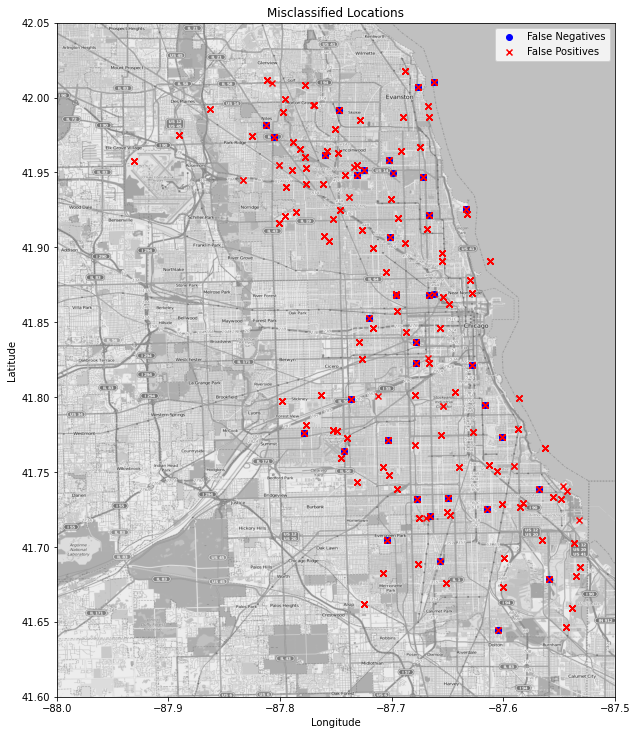

In [ ]:
mapdata = np.loadtxt("assets/mapdata_copyright_openstreetmap_contributors.txt")

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.05)

plt.figure(figsize=(10,16))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)

# false negative locations
plt.scatter(falseneg['Longitude_x'], falseneg['Latitude_x'], marker='o', c='b', label='False Negatives')

# false positive locations
plt.scatter(falsepos['Longitude_x'], falsepos['Latitude_x'], marker='x', c='r', label='False Positives')

plt.title('Misclassified Locations')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('./assets/misclassified_map.png');

Our aim is to minimise the False Negatives as much as possible. Although the False Positive Error would mean increase in government expenditure in terms of prevention, due to the value of human life and the quality of living, we felt that the utility from a False Negative Error outweighs the False Positive Error as failure to identify the presence of WNV when it is present would mean a higher exposure to the virus.

Let's try to understand our False Negative further. From the image below, we can immediately identify the features with the highest coefficient. We will see how the misclassifed locations have been affected by these coefficients.

<img src="../assets/final_model.png" width="800"/>

In [ ]:
falseneg[['Depart','humidlag2','r_humid','rainlag4','lowvis']]

,Depart,humidlag2,r_humid,rainlag4,lowvis
27,8.000,80.000,51,0.410,0.000
100,8.000,80.000,51,0.410,0.000
148,8.000,80.000,51,0.410,0.000
202,8.000,80.000,51,0.410,0.000
242,8.000,80.000,51,0.410,0.000
572,8.000,80.000,51,0.410,0.000
666,8.000,80.000,51,0.410,0.000
691,8.000,80.000,51,0.410,0.000
747,8.000,80.000,51,0.410,0.000
752,8.000,80.000,51,0.410,0.000


In [ ]:
# looking at false negative summarised values
falseneg[['Depart','humidlag2','r_humid','rainlag4','lowvis']].describe()

,Depart,humidlag2,r_humid,rainlag4,lowvis
count,45.000,45.000,45.000,45.000,45.000
mean,0.233,64.200,50.200,0.248,0.000
std,4.772,15.356,2.744,0.259,0.000
min,-3.000,50.000,48.000,0.020,0.000
25%,-3.000,50.000,48.000,0.020,0.000
50%,-3.000,50.000,48.000,0.020,0.000
75%,8.000,80.000,51.000,0.410,0.000
max,8.000,81.000,55.000,0.640,0.000


In [ ]:
# contrasting with X_train summarised values
final_train[['Depart','humidlag2','r_humid','rainlag4','lowvis']].describe()

,Depart,humidlag2,r_humid,rainlag4,lowvis
count,10506.000,10506.000,10506.000,10506.000,10506.000
mean,3.232,63.324,63.515,1.001,0.334
std,6.508,10.105,8.986,0.992,0.420
min,-11.000,39.000,42.000,0.010,0.000
25%,-1.500,56.000,56.000,0.400,0.000
50%,4.000,63.000,62.000,0.665,0.000
75%,7.500,71.000,73.000,1.315,0.500
max,19.000,87.000,87.000,4.560,1.000


In [ ]:
falseneg[['Week','Sunrise','WinterDepart','Tmax','Cool','Month','Species_x','Tmin','WeekPrecipTotal','Sunset','YearWeek','humidlag4']]

,Week,Sunrise,WinterDepart,Tmax,Cool,Month,Species_x,Tmin,WeekPrecipTotal,Sunset,YearWeek,humidlag4
27,24,416.000,-0.300,86.000,10.000,6,0.000,63.500,0.710,1926.000,200824,71.000
100,24,416.000,-0.300,86.000,10.000,6,0.000,63.500,0.710,1926.000,200824,71.000
148,24,416.000,-0.300,86.000,10.000,6,0.000,63.500,0.710,1926.000,200824,71.000
202,24,416.000,-0.300,86.000,10.000,6,2.000,63.500,0.710,1926.000,200824,71.000
242,24,416.000,-0.300,86.000,10.000,6,2.000,63.500,0.710,1926.000,200824,71.000
572,24,416.000,-0.300,86.000,10.000,6,0.000,63.500,0.710,1926.000,200824,71.000
666,24,416.000,-0.300,86.000,10.000,6,2.000,63.500,0.710,1926.000,200824,71.000
691,24,416.000,-0.300,86.000,10.000,6,0.000,63.500,0.710,1926.000,200824,71.000
747,24,416.000,-0.300,86.000,10.000,6,0.000,63.500,0.710,1926.000,200824,71.000
752,24,416.000,-0.300,86.000,10.000,6,2.000,63.500,0.710,1926.000,200824,71.000


In [ ]:
falseneg[['Week','Sunrise','WinterDepart','Tmax','Cool','Month','Species_x','Tmin','WeekPrecipTotal','Sunset','YearWeek','humidlag4']].describe()

,Week,Sunrise,WinterDepart,Tmax,Cool,Month,Species_x,Tmin,WeekPrecipTotal,Sunset,YearWeek,humidlag4
count,45.000,45.000,45.000,45.000,45.000,45.000,45.000,45.000,45.000,45.000,45.000,45.000
mean,24.933,416.200,-0.300,79.867,4.100,6.000,0.667,57.733,0.383,1928.600,200824.933,62.667
std,0.688,0.405,0.000,4.398,3.843,0.000,0.879,3.522,0.244,1.763,0.688,11.935
min,24.000,416.000,-0.300,76.000,1.000,6.000,0.000,55.500,0.165,1926.000,200824.000,52.000
25%,24.000,416.000,-0.300,76.000,1.000,6.000,0.000,55.500,0.165,1926.000,200824.000,52.000
50%,25.000,416.000,-0.300,76.000,1.000,6.000,0.000,55.500,0.165,1929.000,200825.000,52.000
75%,25.000,416.000,-0.300,86.000,10.000,6.000,2.000,63.500,0.710,1929.000,200825.000,71.000
max,26.000,417.000,-0.300,86.000,10.000,6.000,2.000,63.500,0.710,1931.000,200826.000,80.000


In [ ]:
# contrasting with X_train summarised values
final_train[['Week','Sunrise','WinterDepart','Tmax','Cool','Month','Species','Tmin','WeekPrecipTotal','Sunset','YearWeek','humidlag4']].describe()

,Week,Sunrise,WinterDepart,Tmax,Cool,Month,Species,Tmin,WeekPrecipTotal,Sunset,YearWeek,humidlag4
count,10506.000,10506.000,10506.000,10506.000,10506.000,10506.000,10506.000,10506.000,10506.000,10506.000,10506.000,10506.000
mean,31.687,468.457,-0.192,81.917,8.909,7.693,1.679,63.647,0.995,1870.855,200989.311,60.991
std,4.527,45.513,4.818,8.273,5.713,1.068,0.527,7.487,0.962,63.177,234.822,10.878
min,22.000,416.000,-7.900,57.500,0.000,5.000,0.000,42.500,0.000,1720.000,200722.000,39.000
25%,28.000,429.000,-3.200,78.000,5.000,7.000,1.000,59.500,0.400,1832.000,200734.000,54.000
50%,31.000,449.000,2.800,83.000,9.500,8.000,2.000,65.500,0.665,1907.000,200932.000,60.000
75%,35.000,514.000,4.100,88.000,13.500,8.000,2.000,69.500,1.255,1924.000,201137.000,68.000
max,41.000,557.000,4.100,96.500,20.500,10.000,2.000,77.500,4.000,1931.000,201339.000,87.000


Looking at the False Negative, we can attribute to the following:

- Generally higher feature values in `Depart` `humidlag2` `r_humid` `lowvis` as compared to the train values. (Above the train average)
- Generally lower feature values in `Week` `Sunrise` `WinterDepart` as compared to the train values. (Below the train average)

In [ ]:
falsepos[['Depart','humidlag2','r_humid','rainlag4','lowvis']]

,Depart,humidlag2,r_humid,rainlag4,lowvis
13,8.000,80.000,51,0.410,0.000
15,8.000,80.000,51,0.410,0.000
16,8.000,80.000,51,0.410,0.000
19,8.000,80.000,51,0.410,0.000
20,8.000,80.000,51,0.410,0.000
...,...,...,...,...,...
3123,-1.500,81.000,55,0.640,0.000
3124,-1.500,81.000,55,0.640,0.000
3129,-1.500,81.000,55,0.640,0.000
3134,-1.500,81.000,55,0.640,0.000


In [ ]:
falsepos[['Depart','humidlag2','r_humid','rainlag4','lowvis']].describe()

,Depart,humidlag2,r_humid,rainlag4,lowvis
count,742.000,742.000,742.000,742.000,742.000
mean,1.664,68.195,50.613,0.301,0.000
std,5.166,14.879,2.592,0.245,0.000
min,-3.000,50.000,48.000,0.020,0.000
25%,-3.000,50.000,48.000,0.020,0.000
50%,-1.500,80.000,51.000,0.410,0.000
75%,8.000,80.000,51.000,0.410,0.000
max,8.000,81.000,55.000,0.640,0.000


In [ ]:
falsepos[['Week','Sunrise','WinterDepart','Tmax','Cool','Month','Species_x','Tmin','WeekPrecipTotal','Sunset','YearWeek','humidlag4']]

,Week,Sunrise,WinterDepart,Tmax,Cool,Month,Species_x,Tmin,WeekPrecipTotal,Sunset,YearWeek,humidlag4
13,24,416.000,-0.300,86.000,10.000,6,0.000,63.500,0.710,1926.000,200824,71.000
15,24,416.000,-0.300,86.000,10.000,6,0.000,63.500,0.710,1926.000,200824,71.000
16,24,416.000,-0.300,86.000,10.000,6,2.000,63.500,0.710,1926.000,200824,71.000
19,24,416.000,-0.300,86.000,10.000,6,0.000,63.500,0.710,1926.000,200824,71.000
20,24,416.000,-0.300,86.000,10.000,6,0.000,63.500,0.710,1926.000,200824,71.000
...,...,...,...,...,...,...,...,...,...,...,...,...
3123,26,417.000,-0.300,82.000,4.500,6,0.000,56.000,0.530,1931.000,200826,80.000
3124,26,417.000,-0.300,82.000,4.500,6,2.000,56.000,0.530,1931.000,200826,80.000
3129,26,417.000,-0.300,82.000,4.500,6,0.000,56.000,0.530,1931.000,200826,80.000
3134,26,417.000,-0.300,82.000,4.500,6,2.000,56.000,0.530,1931.000,200826,80.000


In [ ]:
# contrasting with X_train summarised values
final_train[['Week','Sunrise','WinterDepart','Tmax','Cool','Month','Species','Tmin','WeekPrecipTotal','Sunset','YearWeek','humidlag4']].describe()

,Week,Sunrise,WinterDepart,Tmax,Cool,Month,Species,Tmin,WeekPrecipTotal,Sunset,YearWeek,humidlag4
count,10506.000,10506.000,10506.000,10506.000,10506.000,10506.000,10506.000,10506.000,10506.000,10506.000,10506.000,10506.000
mean,31.687,468.457,-0.192,81.917,8.909,7.693,1.679,63.647,0.995,1870.855,200989.311,60.991
std,4.527,45.513,4.818,8.273,5.713,1.068,0.527,7.487,0.962,63.177,234.822,10.878
min,22.000,416.000,-7.900,57.500,0.000,5.000,0.000,42.500,0.000,1720.000,200722.000,39.000
25%,28.000,429.000,-3.200,78.000,5.000,7.000,1.000,59.500,0.400,1832.000,200734.000,54.000
50%,31.000,449.000,2.800,83.000,9.500,8.000,2.000,65.500,0.665,1907.000,200932.000,60.000
75%,35.000,514.000,4.100,88.000,13.500,8.000,2.000,69.500,1.255,1924.000,201137.000,68.000
max,41.000,557.000,4.100,96.500,20.500,10.000,2.000,77.500,4.000,1931.000,201339.000,87.000


We can see the inverse for the False Positives:

- Generally lower feature values in `Depart` `humidlag2` `r_humid` `lowvis` as compared to the train values. (Above the train average)
- Generally higher feature values in `Week` `Sunrise` `WinterDepart` as compared to the train values. (Below the train average)

We can attribute the misclassifications occur when mosquitoes breeding were not ideal. 
Since We do not know enough as to why WNV might be present, we could only hypothesise as to why WNV would be present.
A reason would be the [American Robin](https://news.wisc.edu/do-chicagos-suburbs-hold-the-key-to-understanding-west-nile-virus/) that is able to carry the WNV when most birds tend to die shortly after being infected. Understanding the data of other contributing factors to the WNV might be the key to further understand and control the WNV in Chicago.

### Prediction Analysis

In [ ]:
sub_df = submissions

In [ ]:
pred_df = pd.merge(sub_df, test)

In [ ]:
danger_df = pred_df[pred_df['WnvPresent'] > 0.5]

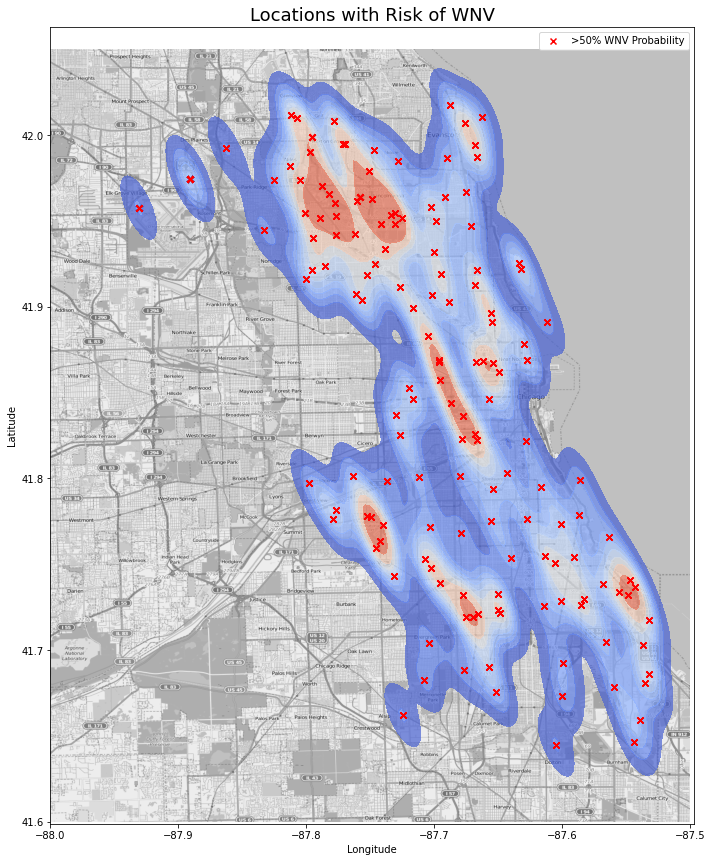

In [ ]:
mapdata = np.loadtxt("./assets/mapdata_copyright_openstreetmap_contributors.txt")

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.05)

plt.figure(figsize=(10,16))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)

# KDE plot of all predicted cases
sns.kdeplot(data=pred_df, x='Longitude', y='Latitude', fill=True, cmap='coolwarm', alpha = 0.7)

# Plot moderate probability
plt.scatter(data=pred_df[pred_df['WnvPresent'] > 0.5], x='Longitude', y='Latitude', marker='x', 
            color='black', label='>50% WNV Probability')

# Plot very high probability
plt.scatter(data=pred_df[pred_df['WnvPresent'] > 0.8], x='Longitude', y='Latitude', 
            s=300, facecolors='none', edgecolors='red', linewidth = 1.5, label='>80% WNV Probability')

plt.title('Locations with Risk of WNV', fontsize=18)
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.savefig('kdeplot_80_locations.png', dpi=300);